# Add a module: DiffusePropagation

Second step is to implement our own Module in CRPropa. To do that we copied the SimplePropagation module and named it DiffusePropagation. To do that we made this copies of the SimplePropagation:

    include/crpropa/module/DiffusePropagation.h
    src/module/DiffusePropagation.cpp

And we added lines similar to the ones containing "SimplePropagation" to this files:

    CMakeLists.txt
    include/CRPropa.h
    python/2_headers.i

If you want to run this notebook, you will need that extended CRPropa version. You can get it as a separate branch 'DiffusePropagation' in my personal clone of CRPropa:

https://github.com/oliver-pola/CRPropa3/tree/DiffusePropagation

In [1]:
from crpropa import *

We stay with our most simple model but now just exchange SimplePropagation by the new DiffusePropagation.

In [2]:
sim = ModuleList()
sim.add(DiffusePropagation(0.1*Mpc, 0.1*Mpc))
sim.add(MaximumTrajectoryLength(100*Mpc))

The trajectory will be stored in a file and a source is generating protons.

In [3]:
output = TextOutput('trajectory.txt', Output.Trajectory3D) 
sim.add(output)

source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourceIsotropicEmission())
source.add(SourcePosition(Vector3d(0, 0, 0)*Mpc))

The simulation starts with source generating 30 particles.

In [4]:
sim.run(source, 30, False)

To plot the trajectories we use matplotlib.

<IPython.core.display.Javascript object>


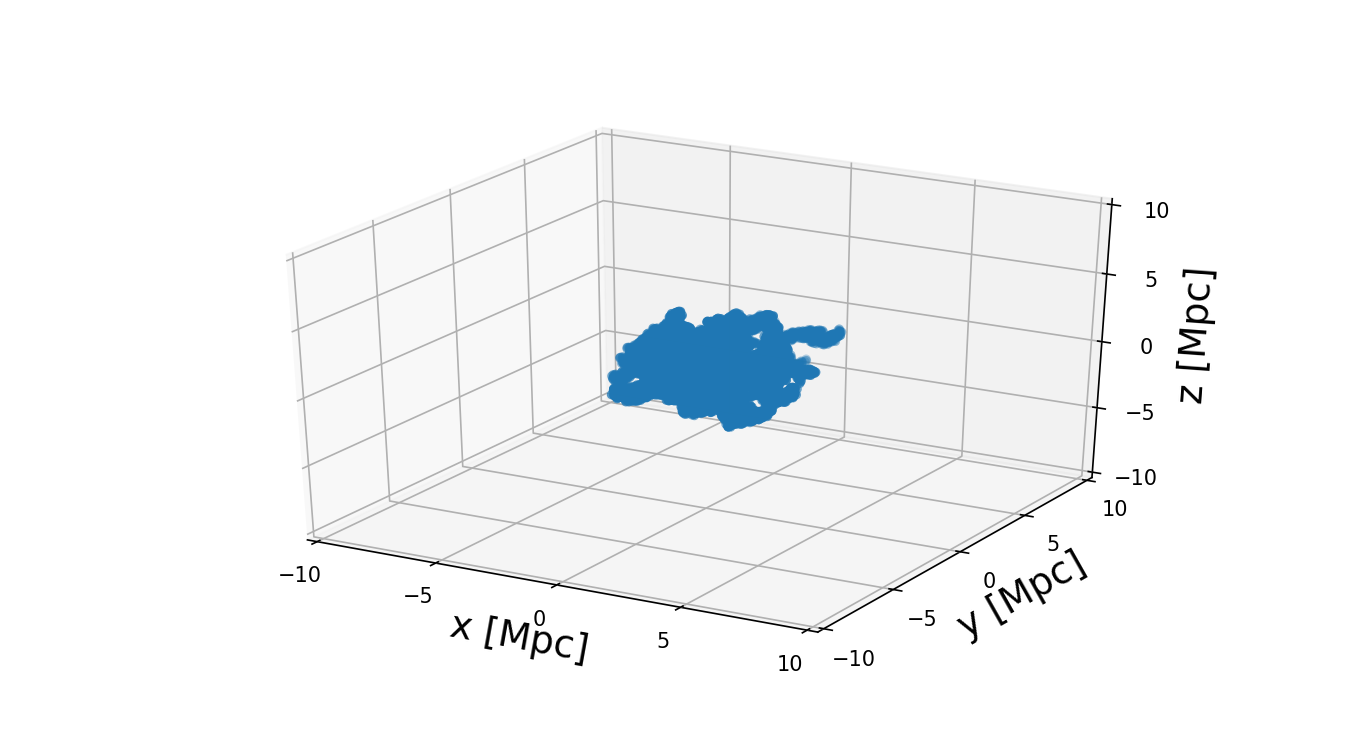

In [5]:
%matplotlib notebook
from pylab import *
from mpl_toolkits.mplot3d import axes3d

output.close()
data = genfromtxt('trajectory.txt', names=True)

# trajectory points
x, y, z = data['X'], data['Y'], data['Z']

fig = plt.figure(figsize=(9, 5))#plt.figaspect(0.5))
ax = fig.gca(projection='3d')# , aspect='equal'

ax.scatter(x,y,z, 'o', lw=0)

ax.set_xlabel('x [Mpc]', fontsize=18)
ax.set_ylabel('y [Mpc]', fontsize=18)
ax.set_zlabel('z [Mpc]', fontsize=18)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))
ax.xaxis.set_ticks((-10, -5, 0, 5, 10))
ax.yaxis.set_ticks((-10, -5, 0, 5, 10))
ax.zaxis.set_ticks((-10, -5, 0, 5, 10))

show()

Instead of this bunch of points we want to plot an overview how far away from the origin the particles have travelled. We call that the radius r. The overall distance travelled back and forth again is called d from CPPropa. To get the relation to diffusion constant D we plot the average of the squared radii < r² >.

But first we do some conversion on our data to get the info we need.

In [6]:
from collections import defaultdict
import numpy as np
grouped = defaultdict(list)
d = []
r_sq = []
d_end = 0
#print(data.dtype.names)
for di, ID, E, X, Y, Z, Px, Py, Pz in data:
    grouped[di].append(X**2 + Y**2 + Z**2)
for di in grouped: 
    d.append(di)
    r_sq.append(np.mean(grouped[di]))
    d_end = max(d_end, di)
print('After last step:')
print('r_min   = ' + str(sqrt(np.min(grouped[d_end]))))
print('r_max   = ' + str(sqrt(np.max(grouped[d_end]))))
r_avg = np.mean(sqrt(grouped[d_end]))
print('< r >   = ' + str(r_avg))
print('< r >²  = ' + str(r_avg**2))
r_sq_avg = np.mean(grouped[d_end])
print('< r² >  = ' + str(r_sq_avg))
print('sigma_r = ' + str(sqrt(r_sq_avg - r_avg**2)))


After last step:
r_min   = 0.202447321142
r_max   = 6.07692655494
< r >   = 3.08446295694
< r >²  = 9.51391173276
< r² >  = 11.0156978706
sigma_r = 1.22547384217


<IPython.core.display.Javascript object>


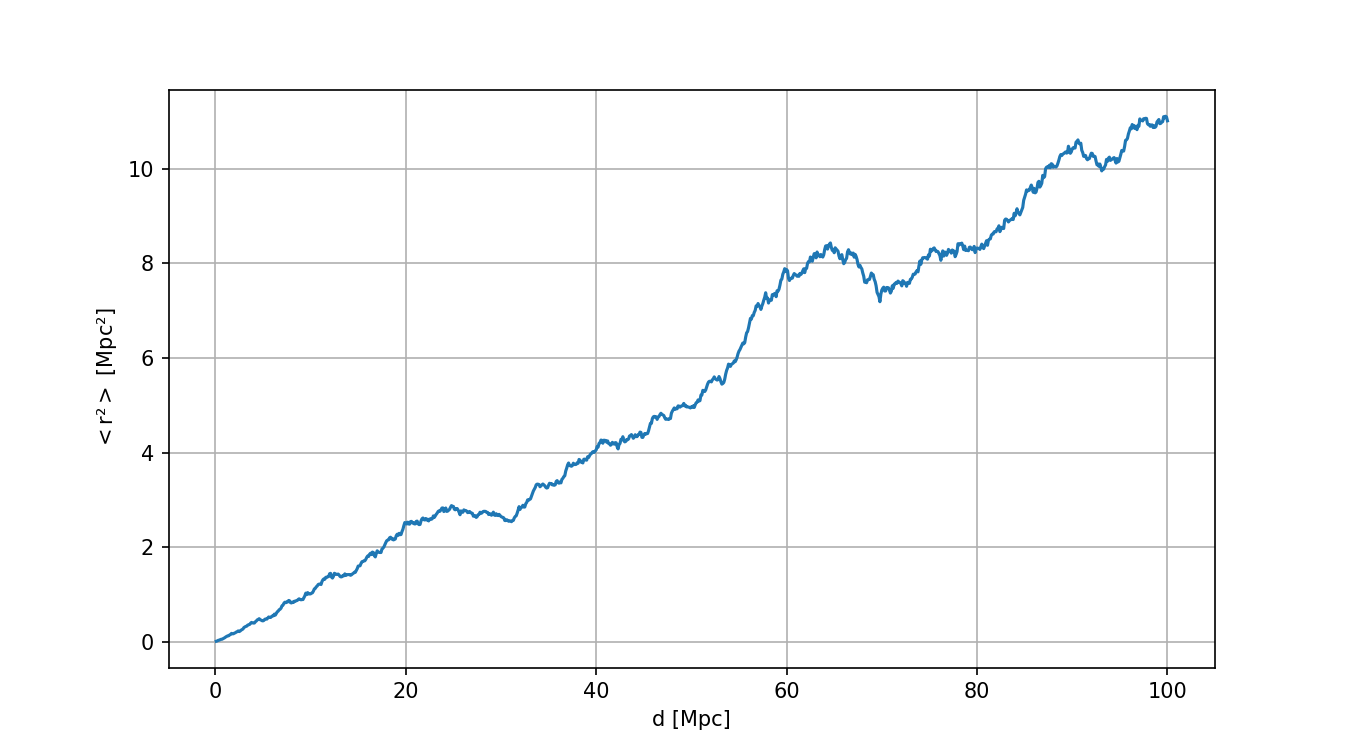

In [7]:
figure(figsize=(9, 5))
plot(d, r_sq)
grid()
ylabel('$<$r²$>$ [Mpc²]')
xlabel('d [Mpc]')
show()

Then the diffusion constant D is the slope of the line approaching this curve.

In [9]:
#TODO This is from last point only, rather use linear regression
D = np.max(r_sq) / np.max(d)
print('D = ' + str(D))

D = 0.11112065187
